In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import messagebox
from osgeo import gdal
from skimage.io import imread, imsave, imshow
import cv2
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
from pyefd import elliptic_fourier_descriptors, normalize_efd, reconstruct_contour
import csv 
from skimage import transform, exposure
from sklearn.decomposition import IncrementalPCA
from numpy.fft import fft2, fftshift

def compute_wavelength_profile(cropped_hsi, cropped_thresh):
    """Compute the mean intensity across spectral bands for each crop, excluding background."""
    wavelength_profiles = []
    
    # Loop over each cropped region
    for crop_hsi, crop_thresh in zip(cropped_hsi, cropped_thresh):
        mean_intensity_per_band = []
        
        # For each spectral band in the HSI image (assumed to be along axis 2)
        num_bands = crop_hsi.shape[2]
        for band in range(num_bands):
            # Extract the band and corresponding threshold mask
            band_image = crop_hsi[:, :, band]
            thresh_mask = crop_thresh != 255  # Mask where the pixels are not background
            
            # Compute mean intensity of non-background pixels
            mean_intensity = np.mean(band_image[thresh_mask])
            mean_intensity_per_band.append(mean_intensity)
        
        # Store the intensity profile for the current crop
        wavelength_profiles.append(mean_intensity_per_band)
    
    return wavelength_profiles

def plot_wavelength_profiles(wavelength_profiles, num_crops):
    """Plot the wavelength profile for each cropped image."""
    for i, profile in enumerate(wavelength_profiles):
        plt.plot(profile, label=f'Crop {i + 1}')
    
    plt.xlabel('Band Index')
    plt.ylabel('Mean Intensity (Excluding Background)')
    plt.title(f'Wavelength Profiles for {num_crops} Crops')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

def save_mean_std_wavelength_profiles_to_csv(wavelength_profiles, species, file_name='wavprofile.csv'):
    """Compute and save the mean and std of the wavelength profiles across all crops to a CSV file."""
    # Convert the list of wavelength profiles to a NumPy array
    wavelength_profiles = np.array(wavelength_profiles)
    
    # Compute mean and std across all crops for each band (axis 0 is the crop dimension)
    mean_profile = np.mean(wavelength_profiles, axis=0)
    std_profile = np.std(wavelength_profiles, axis=0)
    
    # Create a dictionary for the data to save with 160 columns (80 for mean, 80 for std)
    data = {'Species': [species]}
    
    # Add mean and std columns for each band (Band_100 to Band_179)
    for band in range(100, 180):
        data[f'mean_{band}'] = [mean_profile[band]]
        data[f'std_{band}'] = [std_profile[band]]
    
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(data)
    
    # Check if the file already exists
    file_exists = os.path.isfile(file_name)
    
    if not file_exists:
        # If file doesn't exist, create a header row with 'Species', 'mean_100', 'std_100', ..., 'mean_179', 'std_179'
        columns = ['Species']
        for band in range(100, 180):
            columns.append(f'mean_{band}')
            columns.append(f'std_{band}')
        
        # Create a DataFrame with just the column names and write to CSV
        header_df = pd.DataFrame(columns=[columns])
        header_df.to_csv(file_name, mode='w', index=False, header=True)
    
    # Save the DataFrame to CSV (append if file exists, otherwise create)
    df.to_csv(file_name, mode='a', index=False, header=False)

def get_reference_values(species_csv, species):
    """Get the reference mean and std values for f2 and f3 from the CSV."""
    with open(species_csv, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row['Species'] == species:
                mean_f2 = float(row['Mean_f2'])
                std_f2 = float(row['Std_f2'])
                mean_f3 = float(row['Mean_f3'])
                std_f3 = float(row['Std_f3'])
                return mean_f2, std_f2, mean_f3, std_f3
    return None
    
def is_within_valid_range(features, mean_f2, std_f2, mean_f3, std_f3):
    """Check if f2 and f3 of the current features are within valid ranges."""
    f2 = features['f2']
    f3 = features['f3']
    
    valid_f2_range = [mean_f2 - 3*std_f2, mean_f2 + 3*std_f2]
    valid_f3_range = [mean_f3 - 3*std_f3, mean_f3 + 3*std_f3]
    
    return (valid_f2_range[0] <= f2 <= valid_f2_range[1]) and (valid_f3_range[0] <= f3 <= valid_f3_range[1])
def canny_edge_detection(img):
    # Apply Canny edge detector
    edges = cv2.Canny(img, 100, 200)
    return edges
    
# Apply Canny edge detection to each crop
def apply_canny_to_crops(cropped_images):
    canny_crops = []
    for i, img in enumerate(cropped_images):
        # Convert image to grayscale if it's in color
        img_gray = np.mean(img,axis=2).astype(img.dtype) # For grayscale or single-channel images

        # Apply Canny edge detection
        edges = canny_edge_detection(img_gray)
        
        # Append the edges to the list
        canny_crops.append(edges)

    return canny_crops


def extract_contours(edge_image):
    """Extract contours from the edge-detected image."""
    contours, _ = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def compute_efd(contours, order=10):
    """Compute the Elliptic Fourier Descriptors for each contour."""
    efd_coeffs = []
    for contour in contours:
        contour = np.squeeze(contour)
        if len(contour) > 10:  # Ensure contour has enough points
            coeffs = elliptic_fourier_descriptors(contour, order=order, normalize=False)
            efd_coeffs.append(coeffs)
    return efd_coeffs

def rescale_contour(contour, original_image_shape):
    """Rescale the reconstructed contour to the original image dimensions."""
    height, width = original_image_shape[:2]
    
    # Normalize contour between 0 and 1 (as EFD often works with normalized coordinates)
    contour_min = np.min(contour, axis=0)
    contour_max = np.max(contour, axis=0)
    
    normalized_contour = (contour - contour_min) / (contour_max - contour_min)
    
    # Scale the normalized contour to the size of the original image
    rescaled_contour = np.zeros_like(normalized_contour)
    rescaled_contour[:, 0] = normalized_contour[:, 0] * width  # Scale x coordinates
    rescaled_contour[:, 1] = normalized_contour[:, 1] * height  # Scale y coordinates
    
    return rescaled_contour

def reconstruct_shape(coeffs, original_image_shape):
    """Reconstruct the shape from normalized EFD coefficients."""
    # Normalize EFD coefficients
    coeffs = normalize_efd(coeffs)
    # Reconstruct contour from normalized EFD
    reconstructed_contour = reconstruct_contour(coeffs, locus=(0, 0), num_points=500)
    
    # Rescale the reconstructed contour to the original image dimensions
    rescaled_contour = rescale_contour(reconstructed_contour, original_image_shape)
    
    return rescaled_contour

def plot_contours(original_img, original_contours, reconstructed_contours, contour_features, image_index):
    """Plot the original contours and the reconstructed ones side by side, 
    with morphological features marked on the reconstructed contours."""
    plt.figure(figsize=(12, 6))

    # Plot original contours
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    for contour in original_contours:
        contour = np.squeeze(contour)
        plt.plot(contour[:, 0], contour[:, 1], color='blue')
    plt.title("Original Contours")

    # Plot reconstructed contours with features
    plt.subplot(1, 2, 2)
    plt.imshow(np.ones((200,60)) * 255, cmap='gray')  # White background
    
    for idx, (contour, features) in enumerate(zip(reconstructed_contours, contour_features)):
        plt.plot(contour[:, 0], contour[:, 1], color='red')
        
        # Calculate the center of the contour
        center_x = np.mean(contour[:, 0])
        center_y = np.mean(contour[:, 1])
        
        # Mark major and minor axis lengths
        plt.text(center_x, center_y, f"f2: {features['f2']:.2f}\nf3: {features['f3']:.2f}", 
                ha='center', va='center', fontsize=8, color='green')
        
    plt.title("Reconstructed Contours from EFD")

    plt.tight_layout()
    plt.show()

def compute_morphological_features(contour):
    """Compute morphological features of the given contour."""
    if len(contour.shape) == 2:
        contour = np.expand_dims(contour, axis=1)
    contour = np.array(contour, dtype=np.float32)
    features = {}

    # Feature f1: Area (number of pixels inside the contour)
    f1_area = cv2.contourArea(contour)
    
    # Feature f5: Perimeter (number of pixels along the boundary)
    f5_perimeter = cv2.arcLength(contour, True)
    
    # Check if the contour has enough points to fit an ellipse
    if len(contour) >= 5:
        # Fit an ellipse to the contour
        ellipse = cv2.fitEllipse(contour)
        
        # Get major and minor axis lengths (f2 and f3)
        (center, (major_axis_length, minor_axis_length), angle) = ellipse
        
        f2_major_axis_length = max(major_axis_length, minor_axis_length)  # Major axis
        f3_minor_axis_length = min(major_axis_length, minor_axis_length)  # Minor axis
        
        # Feature f4: MinorAxisLength / MajorAxisLength
        f4_axis_ratio = f3_minor_axis_length / f2_major_axis_length
        
        # Feature f6: FociDistance / MajorAxisLength (Eccentricity)
        foci_distance = np.sqrt(f2_major_axis_length**2 - f3_minor_axis_length**2)
        f6_eccentricity = foci_distance / f2_major_axis_length
    else:
        # If there are not enough points to fit an ellipse, set features to zero or NaN
        f2_major_axis_length = f3_minor_axis_length = f4_axis_ratio = f6_eccentricity = np.nan
    
    # Feature f5: Perimeter / Area
    f5_perimeter_area_ratio = f5_perimeter / f1_area if f1_area != 0 else np.nan
    
    # Store features in a dictionary
    features['f1'] = f1_area
    features['f2'] = f2_major_axis_length
    features['f3'] = f3_minor_axis_length
    features['f4'] = f4_axis_ratio
    features['f5'] = f5_perimeter_area_ratio
    features['f6'] = f6_eccentricity
    
    return features
def apply_closing(canny_image, kernel_size=(3, 3)):
    """
    Apply morphological closing on the given image.
    
    Parameters:
    canny_image (np.ndarray): The input edge-detected image (e.g., from Canny edge detection).
    kernel_size (tuple): The size of the structuring element (kernel) used for closing.

    Returns:
    np.ndarray: The image after applying morphological closing.
    """
    image=canny_image
    for i in range(5):
        # Create a structuring element (kernel) for closing
        kernel = np.ones(kernel_size, np.uint8)
        
        # Apply morphological closing (dilation followed by erosion)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    closed_image = image
    return closed_image
def compute_features_for_contours(contours):
    """Compute morphological features for each contour."""
    all_features = []
    for contour in contours:
        features = compute_morphological_features(contour)
        all_features.append(features)
    return all_features

def remove_small_contours(image, min_area=80):
    """
    Remove small contours from the image based on a minimum area threshold.
    
    Parameters:
    image (np.ndarray): The input binary image (typically an edge-detected or thresholded image).
    min_area (int): The minimum area threshold for keeping contours. Contours with area smaller than this will be removed.

    Returns:
    np.ndarray: The image with small contours removed.
    """
    # Find all contours in the image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create an empty mask to draw the filtered contours
    mask = np.zeros_like(image)
    
    # Loop over each contour
    for contour in contours:
        # Calculate the contour area
        area = cv2.contourArea(contour)
        
        # If the contour area is larger than the minimum area, draw it on the mask
        if area >= min_area:
            cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)  # Fill the contour
    
    return mask
def draw_contours_on_image(image, contours):
    """
    Draw contours on the original image and display them.

    Parameters:
    image (np.ndarray): The original image or edge-detected image (e.g., Canny image).
    contours (list): List of contours to draw on the image.

    Returns:
    None: Displays the image with contours using matplotlib.
    """
    # Create a copy of the original image to draw on
    image_with_contours = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert grayscale image to BGR for colored contours
    
    # Draw the contours on the image (green color with thickness of 2)
    cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)
    
    # Display the result using matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display in matplotlib
    plt.title('Contours Overlayed on the Image')
    plt.axis('off')
    plt.show()
def clean_image(canny_image):
    # Step 1: Apply morphological closing with a kernel size of (1, 1)
    closed_canny_image = apply_closing(canny_image, kernel_size=(3, 3))
    # Step 2: Remove small contours based on area
    cleaned_canny_image = remove_small_contours(closed_canny_image, min_area=80)
    return cleaned_canny_image
def compute_mean_and_std_for_all_crops(all_features):
    """Compute the mean and std for each feature (f1 to f6) across all crops."""
    features_array = {f'f{i}': [] for i in range(1, 7)}
    
    for features in all_features:
        for key in features_array.keys():
            features_array[key].append(features[key])

    mean_features = {key: np.nanmean(values) for key, values in features_array.items()}
    std_features = {key: np.nanstd(values) for key, values in features_array.items()}

    return mean_features, std_features
def save_mean_std_to_csv(species, mean_features, std_features, file_path='Morphological_all.csv'):
    file_exists = os.path.isfile(file_path)
    with open(file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(['Species', 'Mean_f1', 'Mean_f2', 'Mean_f3', 'Mean_f4', 'Mean_f5', 'Mean_f6',
                             'Std_f1', 'Std_f2', 'Std_f3', 'Std_f4', 'Std_f5', 'Std_f6'])
        
        mean_row = [mean_features[f'f{i}'] for i in range(1, 7)]
        std_row = [std_features[f'f{i}'] for i in range(1, 7)]
        
        writer.writerow([species] + mean_row + std_row)
        
def is_closed_contour(contour, tolerance=3):
    """Check if the contour is 'closed' by comparing the start and end points."""
    start_point = contour[0]
    end_point = contour[-1]
    distance = np.linalg.norm(start_point - end_point)
    return distance < tolerance

def radial_profile(data):
    """Computes the radial profile of a 2D FFT result."""
    y, x = np.indices((data.shape))
    center = np.array([y.max() // 2, x.max() // 2])  # Find the center of the FFT image
    
    r = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)  # Radial distance from the center
    r = r.astype(int)  # Round distances to integers
    
    # Compute the mean value for all points at the same radial distance
    radial_mean = np.bincount(r.ravel(), data.ravel()) / np.bincount(r.ravel())
    
    return radial_mean

def compute_fft_spectrum(img, low_freq_cutoff):
    """Computes the 2D FFT and radial mean profile of the image, with low frequencies removed."""
    # Perform FFT
    fft = np.fft.fft2(img)
    fft_shifted = np.fft.fftshift(fft)
    
    # Compute the magnitude spectrum
    magnitude_spectrum = np.abs(fft_shifted)
    
    # Remove low-frequency bins (around the center)
    center = (magnitude_spectrum.shape[0] // 2, magnitude_spectrum.shape[1] // 2)
    magnitude_spectrum[center[0] - low_freq_cutoff:center[0] + low_freq_cutoff, center[1] - low_freq_cutoff:center[1] + low_freq_cutoff] = 0
    
    # Compute radial profile (amplitude as a function of frequency)
    radial_mean = radial_profile(magnitude_spectrum)
    
    return magnitude_spectrum, radial_mean


def plot_fft_and_radial(spectrum, radial_mean, crop_index):
    """Plots both the 2D FFT magnitude spectrum and the radial profile."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot 2D FFT magnitude spectrum
    ax1.imshow(np.log(1 + spectrum), cmap='gray')
    ax1.set_title(f'2D FFT Magnitude Spectrum (Crop {crop_index + 1})')
    ax1.axis('off')
    
    # Plot radial mean profile
    ax2.plot(radial_mean, label=f'Crop {crop_index + 1}')
    ax2.set_title('Amplitude-Versus-Frequency Spectrum')
    ax2.set_xlabel('Frequency (Radial Distance)')
    ax2.set_ylabel('Amplitude (Mean Magnitude)')
    plt.savefig(f"spectrum_rgb_{crop_index}_BC15-01.png")
    plt.tight_layout()
    plt.show()

def compute_spectra_for_crops(cropped_imgs,lowfrequency_cutoff):
    """Computes the amplitude-versus-frequency spectra for all cropped images."""
    radial_profiles=[]
    for idx, img in enumerate(cropped_imgs):
        if len(img.shape) == 3:  # For RGB images
            # Convert to grayscale by averaging the color channels
            img_gray = np.mean(img, axis=2)
        else:
            img_gray = img  # For grayscale or single-channel images
            
        # Compute the FFT spectrum and radial mean
        magnitude_spectrum, radial_mean = compute_fft_spectrum(img_gray,lowfrequency_cutoff)
        radial_profiles.append(radial_mean)
        # Plot both 2D FFT and radial profile
        plot_fft_and_radial(magnitude_spectrum, radial_mean, idx)
    return radial_profiles

def truncate_profiles_to_min_length(radial_profiles):
    """Truncates all radial profiles to the minimum length found in the data."""
    min_length = min([len(profile) for profile in radial_profiles])  # Find the minimum length
    truncated_profiles = [profile[:min_length] for profile in radial_profiles]  # Truncate each profile
    return np.array(truncated_profiles)

def compute_mean_and_std(radial_profiles):
    """Computes the mean and standard deviation of the truncated radial profiles for all images."""
    # Truncate the profiles to the minimum length
    truncated_profiles = truncate_profiles_to_min_length(radial_profiles)
    
    # Compute the mean and standard deviation across the images for each frequency
    mean_amplitude = np.mean(truncated_profiles, axis=0)
    std_amplitude = np.std(truncated_profiles, axis=0)
    
    return mean_amplitude, std_amplitude

def plot_mean_and_std(mean_amplitude, std_amplitude=None):
    """Plot the mean amplitude with optional standard deviation curves."""
    frequencies = np.arange(len(mean_amplitude))  # Frequency axis (indices)
    
    plt.figure(figsize=(8, 6))
    
    # Plot mean amplitude
    plt.plot(frequencies, mean_amplitude, label='Mean Amplitude', color='blue')
    
    # Optionally, plot mean ± std curves
    if std_amplitude is not None:
        plt.plot(frequencies, mean_amplitude + std_amplitude, '--', color='green', label='Mean + Std')
        plt.plot(frequencies, mean_amplitude - std_amplitude, '--', color='red', label='Mean - Std')
    
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.title('Mean Amplitude Spectrum (with Std. Deviation)')
    plt.legend()
    plt.grid(True)
    plt.show()

def compute_pixel_boundaries(img):
    """Get the maximum boundary value for the image's data type."""
    dtype = img.dtype
    if np.issubdtype(dtype, np.integer):
        return np.iinfo(dtype).max  # Max value for integer types
    elif np.issubdtype(dtype, np.floating):
        return 1.0  # Assume normalized floating-point values are between 0 and 1
    return 1  # Default to 1 if unknown

def normalize_values(values, img):
    """Normalize the values based on the image dtype."""
    boundary = compute_pixel_boundaries(img)
    return values / boundary

def save_max_mean_and_std_csv(species, max_mean, max_std, file_path='Spectrum_all.csv'):
    """Save the max mean and std for the given species in a CSV file."""
    # Open the CSV file in append mode
    file_exists = os.path.isfile(file_path)
    
    with open(file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header if the file is newly created
        if not file_exists:
            writer.writerow(['Species', 'Max Mean', 'Max Std'])
        
        # Write the species, max_mean, and max_std to the CSV
        writer.writerow([species, max_mean, max_std])
    
    print(f"Max mean and std saved for {species} in {file_path}")
    
def resample_hsi(hsi, target_shape):
    # Resample the downsampled HSI image to match the RGB image's spatial resolution
    hsi_resampled = transform.resize(hsi.astype(np.float32), target_shape, mode='reflect', anti_aliasing=True, preserve_range=True)   
    return hsi_resampled.astype(np.float32)

def perform_incremental_pca(hsi_resampled, n_components, batch_size):
    # Flatten the HSI image for PCA
    hsi_flat = hsi_resampled.reshape(-1, hsi_resampled.shape[2])
   
    # Initialize IncrementalPCA
    ipca = IncrementalPCA(n_components=n_components)
    
    # Perform Incremental PCA in batches to manage memory
    for i in range(0, hsi_flat.shape[0], batch_size):
        batch = hsi_flat[i:i + batch_size]
        ipca.partial_fit(batch)
    
    # Transform the data after fitting
    hsi_pca = ipca.transform(hsi_flat)
    
    # Return PCA results and variance ratio
    return hsi_pca, ipca, hsi_flat, ipca.explained_variance_ratio_

def match_histogram(hsi_pc, rgb_channel):
    # Match the histogram of the first principal component with the RGB channel
    matched_pc = exposure.match_histograms(hsi_pc, rgb_channel.flatten())
    return matched_pc

def reconstruct_hsi_batchwise(hsi_pca, ipca, matched_pc, flat_shape, original_shape, batch_size):
    """Perform inverse PCA transform in batches."""
    # Replace the first principal component with the matched one
    hsi_pca[:, 0] = matched_pc
    
    # Initialize an empty array to store the reconstructed HSI image with 256 bands
    hsi_reconstructed_flat = np.zeros(flat_shape, dtype=np.float32)
    
    # Perform inverse transform in batches
    for i in range(0, hsi_pca.shape[0], batch_size):
        batch_pca = hsi_pca[i:i + batch_size]
        batch_reconstructed = ipca.inverse_transform(batch_pca)  # This returns the full 256 bands
        hsi_reconstructed_flat[i:i + batch_size] = batch_reconstructed
    
    # Reshape the flat array back to the original image shape
    hsi_reconstructed = hsi_reconstructed_flat.reshape(original_shape)
    
    return hsi_reconstructed

def run_reconstruction(rgb, hsi, n_components, batch_size):
    # Step 1: Resample HSI to match RGB resolution with downsampling
    hsi_resampled = resample_hsi(hsi, rgb.shape[:2])
    
    # Step 2: Perform Incremental PCA on the resampled HSI image
    hsi_pca, ipca, hsi_flat, explained_variance_ratio = perform_incremental_pca(hsi_resampled, n_components, batch_size)
    
    # Step 3: Match the first principal component with an RGB channel (e.g., the intensity or a specific channel)
    matched_pc = match_histogram(hsi_pca[:, 0], rgb[:, :, 0])  # Using the red channel for matching
    
    # Step 4: Reconstruct the high-resolution HSI image in batches
    hsi_reconstructed = reconstruct_hsi_batchwise(hsi_pca, ipca, matched_pc, hsi_flat.shape, hsi_resampled.shape, batch_size=batch_size)
    
    # Calculate the percentage of energy explained by the first component
    first_component_energy = explained_variance_ratio[0] * 100
    total_energy = np.sum(explained_variance_ratio) * 100  # Total explained energy by all components
    
    print(f"Percentage of energy explained by the first component: {first_component_energy:.2f}%")
    print(f"Total energy explained by all {n_components} components: {total_energy:.2f}%")
    
    return hsi_reconstructed
    
def strench(img):
    # Function to stretch the contrast of the image based on intensity
    nbins = 1000
    tol_low = 0.1
    tol_high = 0.9
    res = np.zeros(img.shape)
    n_bands = 1 if len(img.shape) < 3 else img.shape[2]

    for i in range(n_bands):
        tmp = img if n_bands == 1 else img[:, :, i]
        tmp = tmp - np.min(tmp.ravel())
        tmp = tmp / np.max(tmp.ravel())
        N, _ = np.histogram(tmp.ravel(), nbins)
        cdf = np.cumsum(N)/np.sum(N)  # cumulative distribution function
        ilow = np.where(cdf > tol_low)[0][0]
        ihigh = np.where(cdf >= tol_high)[0][0]
        ilow = (ilow - 1)/(nbins-1)
        ihigh = (ihigh - 1)/(nbins-1)
        li = ilow
        lo = 0
        hi = ihigh
        ho = 255
        out = (tmp < li) * lo
        out = out + np.logical_and(tmp >= li, tmp < hi) * (lo + (ho - lo) * ((tmp - li) / (hi - li)))
        out = out + (tmp >= hi) * ho

        if n_bands == 1:
            res = out
        else:
            res[:, :, i] = out
    return out

def show_img(img: np.ndarray, title: str, cmap: str ='gray') -> None:
    """Shows a grayscale or RGB image after performing a stretching of its dynamic."""
    img_stretched = strench(img)
    plt.figure(figsize=(20, 20))
    plt.title(title)
    plt.imshow(img_stretched.astype('uint8'), cmap=cmap)

def load_hyperspectral_image(file_path):
    dataset = gdal.Open(file_path)
    if not dataset:
        messagebox.showerror("Error", "Failed to open file")
        return None
    bands = dataset.RasterCount
    hyperspectral_image = []
    for i in range(1, bands + 1):
        band = dataset.GetRasterBand(i).ReadAsArray()
        hyperspectral_image.append(band)
    return np.dstack(hyperspectral_image)

def rect(img, mtx, dist, newcameramtx, roi, H):
    """Rectify the given image using calibration parameters."""
    height, width = img.shape[:2]
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    img_rect = cv2.warpPerspective(dst, H, (width, height))
    p, q = img.shape[:2]
    img_rect = img_rect[:p, :q, :]
    plt.figure()
    plt.imshow(img_rect if img_rect.shape[2] <= 200 else img_rect[:, :, 128])
    plt.show()
    return img_rect

# Function to replace zeros with minimum values for each band
def replace_zero_with_min_bandwise(hsi_img):
    for band in range(hsi_img.shape[2]):
        band_data = hsi_img[:, :, band]
        non_zero_values = band_data[band_data > 0]
        if len(non_zero_values) > 0:
            min_non_zero_value = np.min(non_zero_values)
            band_data[band_data == 0] = min_non_zero_value
        hsi_img[:, :, band] = band_data
    return hsi_img

# Threshold processing
def pre(thresh_rgb, size):
    kernel = np.ones((size, size), np.uint8)
    thresh_rgb = cv2.morphologyEx(thresh_rgb, cv2.MORPH_CLOSE, kernel)
    thresh_rgb = cv2.morphologyEx(thresh_rgb, cv2.MORPH_OPEN, kernel)
    return thresh_rgb

def find_and_crop_segments(thresh_img, original_img, padding=5):
    """
    Find segments in the thresholded image and crop corresponding areas 
    from the original image with a small padding around each segment.

    Args:
    - thresh_img: Binary thresholded image (0 for rice grains, 255 for background)
    - original_img: Original image to crop from (RGB or HSI)
    - padding: The amount of surrounding area to include around each segment.

    Returns:
    - crops: List of cropped images from the original image.
    """
    # Find contours where pixel value is 0 (grains)
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    crops = []
    crops_thresh = []
    for contour in contours:
        # Get the bounding box of each contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Add padding to the bounding box
        x_start = max(0, x - padding)
        y_start = max(0, y - padding)
        x_end = min(original_img.shape[1], x + w + padding)
        y_end = min(original_img.shape[0], y + h + padding)
        
        # Crop the original image using the expanded bounding box
        cropped_img = original_img[y_start:y_end, x_start:x_end]
        crops.append(cropped_img)
        cropped_thresh = thresh_img[y_start:y_end, x_start:x_end]
        crops_thresh.append(cropped_thresh)
    return crops,crops_thresh

def convert_list_to_uint8(image_list):
    """
    Converts all elements in a list of images to uint8.
    
    Args:
    - image_list: List of 3D images (each image can be of any dtype).
    
    Returns:
    - uint8_list: List of images where each image is converted to uint8.
    """
    # Convert each element of the list to uint8 using list comprehension
    uint8_list = [img.astype(np.uint8) for img in image_list]  
    return uint8_list

def Extract_rgb_bands(croped_reconstructed):
        croped_reconstruct_rgb = [crops[:,:,rgb_bands] for crops in croped_reconstructed]
        return croped_reconstruct_rgb  

def find_best_band_by_variance(hyper_img):
    max_variance = 0
    best_band = -1
    
    # Loop through each band in the hyperspectral image
    for i in range(hyper_img.shape[2]):
        # Flatten the band to a 1D array
        flattened_band = hyper_img[:, :, i].flatten()
        
        # Compute variance of the flattened band
        variance = np.var(flattened_band)
        
        # Check if this variance is the largest so far
        if variance > max_variance:
            max_variance = variance
            best_band = i
    
    return best_band

In [ ]:
# Set working directory based on species
os.chdir(f'F:\\Hanoi project\\RGB and VIS-NIR HSI Data for 90 Rice Seed Varieties')
index_df = pd.read_csv('index.csv')
# Set the square lengths for HSI and RGB
square_len_hsi = 40
square_len_rgb = 200

for index, row in index_df.iterrows():
    folder = row['Folder']
    file_name = row['File Name']
    species = file_name
    hyperspectral_path = f'./{folder}/{file_name}.raw'
    rgb_path = f'./{folder}/{file_name}.jpg'
    # Load images based on the species
    hyper_img_raw = load_hyperspectral_image(hyperspectral_path)
    rgb_img_raw = imread(rgb_path)
    
    hyper_img = hyper_img_raw[:600, :, :]
    rgb_img = rgb_img_raw[:, 1750:3550, :]
    
    rgb_bands = (101, 61, 33)  # 630nm, 532nm, 465nm
    show_img(hyper_img[:, :, rgb_bands], f'True color of the original image for {species}')
    plt.show()
    plt.imshow(rgb_img)
    plt.show()
    
    
    # Example usage
    best_band_index = find_best_band_by_variance(hyper_img)
    
    hsi_band_raw = hyper_img[:, :, best_band_index]
    hsi_band = strench(hsi_band_raw).astype(np.uint8)
    hsi_band = np.stack([hsi_band] * 3, axis=-1)
    _, thresh_hsi = cv2.threshold(hsi_band[:, :, 0], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    _, thresh_rgb = cv2.threshold(rgb_img[:, :, 0], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Load calibration parameters from .npz files
    hsi_calibration_data = np.load(f'hsi_calibration_parameters.npz')
    rgb_calibration_data = np.load(f'rgb_calibration_parameters.npz')
    
    # Extract calibration data
    mtx_hsi, dist_hsi, newcameramtx_hsi, roi_hsi, H_hsi = (
        hsi_calibration_data['mtx'], hsi_calibration_data['dist'],
        hsi_calibration_data['newcameramtx'], hsi_calibration_data['roi'],
        hsi_calibration_data['H']
    )
    mtx_rgb, dist_rgb, newcameramtx_rgb, roi_rgb, H_rgb = (
        rgb_calibration_data['mtx'], rgb_calibration_data['dist'],
        rgb_calibration_data['newcameramtx'], rgb_calibration_data['roi'],
        rgb_calibration_data['H']
    )
    
    # Rectify images
    img_rect_hsi = rect(hyper_img, mtx_hsi, dist_hsi, newcameramtx_hsi, roi_hsi, H_hsi)
    img_rect_rgb = rect(rgb_img, mtx_rgb, dist_rgb, newcameramtx_rgb, roi_rgb, H_rgb)
    
    # Crop the images based on the rectified results
    cropped_img_rect_hsi = img_rect_hsi[:13 * square_len_hsi, :8 * square_len_hsi]
    cropped_img_rect_rgb = img_rect_rgb[:13 * square_len_rgb, :8 * square_len_rgb]
    
    cropped_img_rect_rgb = replace_zero_with_min_bandwise(cropped_img_rect_rgb)
    cropped_img_rect_hsi = replace_zero_with_min_bandwise(cropped_img_rect_hsi)
    
    # Apply preprocessing
    _, thresh_rgb = cv2.threshold(cropped_img_rect_rgb[:, :, 0], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    _, thresh_hsi = cv2.threshold(cropped_img_rect_hsi[:, :, best_band_index], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    thresh_hsi = pre(thresh_hsi.astype(np.uint8), 3)
    thresh_rgb = pre(thresh_rgb, 10)
    
    # Segmentation keypoint detection (same as before)
    # (use `find_key_points`, `crop`, and `cropped_images` functions as per your previous script)
    
    # Display final images
    plt.imshow(cropped_img_rect_rgb)
    plt.show()
    plt.imshow(cropped_img_rect_hsi[:, :, best_band_index])
    plt.show()
    thresh_rgb[:,:120]=255
    
    thresh_hsi[:,280:]=255
    # Example usage for RGB and HSI images
    thresh_hsi[:,:24]=255
    padding = 10  # Adjust padding as needed
    croped_rgb, croped_thresh_rgb= find_and_crop_segments(255-thresh_rgb, cropped_img_rect_rgb, padding+10)
    croped_hsi, croped_thresh_hsi = find_and_crop_segments(255-thresh_hsi, cropped_img_rect_hsi, padding)
    croped_hsi_uint8 = convert_list_to_uint8(croped_hsi)
    Species=species+'_hsi'

    # Assuming `croped_hsi` is the cropped HSI images and `croped_thresh_hsi` is the corresponding thresholded images
    wavelength_profiles_hsi = compute_wavelength_profile(croped_hsi, croped_thresh_hsi)
    
    # Plot the wavelength profiles for the HSI crops (48 curves)
    #plot_wavelength_profiles(wavelength_profiles_hsi, num_crops=len(wavelength_profiles_hsi))
    
    save_mean_std_wavelength_profiles_to_csv(wavelength_profiles_hsi, Species)

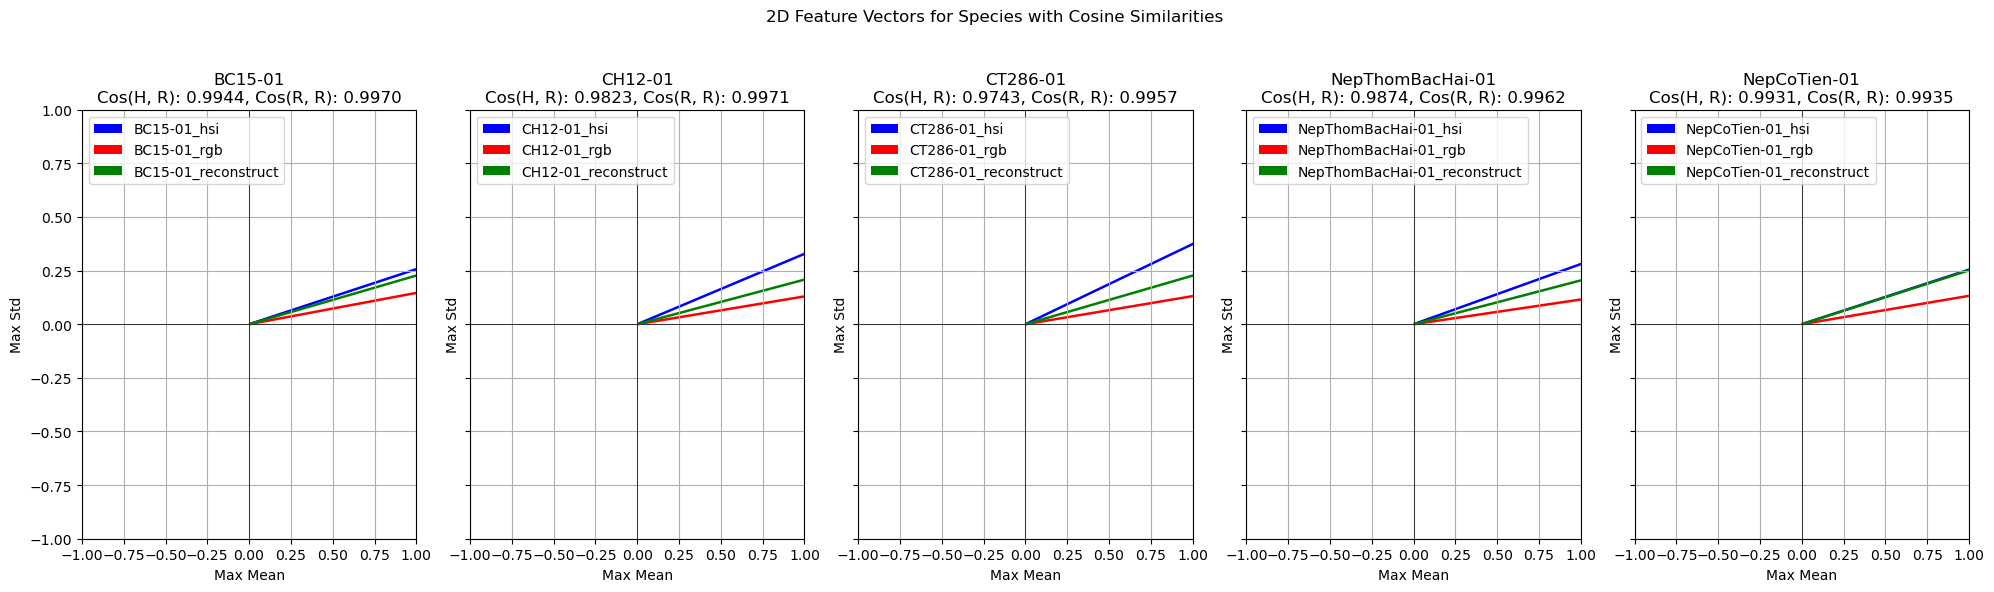

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Set the working directory
os.chdir(f'F:\\Hanoi project\\RGB and VIS-NIR HSI Data for 90 Rice Seed Varieties')

# Read morphological features and spectrum features from CSV
morphological_file = 'Morphological_all.csv'
spectrum_file = 'Spectrum_all.csv'

# Load the CSV data
morphological_data = pd.read_csv(morphological_file)
spectrum_data = pd.read_csv(spectrum_file)

# Function to filter species that end with '01_rgb'
def filter_species(data, max_species=5):
    filtered_data = data[data['Species'].str.endswith('01_rgb')]
    return filtered_data.groupby('Species').head(max_species)  # Get the first 5 species

# Filtered data for first 5 species ending with "01_rgb"
filtered_morphological_data = filter_species(morphological_data)
filtered_spectrum_data = filter_species(spectrum_data)

# Function to plot mean and std for morphological features
def plot_morphological_features_with_mean_std(data):
    species = data['Species'].unique()[:5]  # Take first 5 species
    features = ['Mean_f1', 'Mean_f2', 'Mean_f3', 'Mean_f4', 'Mean_f5', 'Mean_f6']
    std_features = ['Std_f1', 'Std_f2', 'Std_f3', 'Std_f4', 'Std_f5', 'Std_f6']
    
    fig, axs = plt.subplots(3, 2, figsize=(14, 10))  # (3, 2) layout for 6 features
    axs = axs.ravel()  # Flatten axes array for easier access

    for idx, feature in enumerate(features):
        std_feature = std_features[idx]
        
        # Prepare data for the current feature
        mean_values = [data[data['Species'] == sp][feature].values[0] for sp in species]
        std_values = [data[data['Species'] == sp][std_feature].values[0] for sp in species]
        
        # Plot mean with error bars (standard deviation)
        species_labels = [sp for sp in species]
        axs[idx].bar(species_labels, mean_values, yerr=std_values, capsize=5, alpha=0.7)
        axs[idx].set_title(f'{feature} with Std')
        axs[idx].set_xlabel('Species')
        axs[idx].set_ylabel('Mean Value')
        axs[idx].grid(True)
    
    plt.suptitle('Morphological Features (Mean and Std) for Different Species')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Function to plot spectrum features with species on the x-axis
def plot_spectrum_features_together(data):
    species = data['Species'].unique()[:5]  # Take first 5 species

    plt.figure(figsize=(10, 6))

    # Create x-axis labels for species
    species_labels = [sp for sp in species]
    
    # Plot Max Mean and Max Std for each species
    max_means = [data[data['Species'] == sp]['Max Mean'].values[0] for sp in species]
    max_stds = [data[data['Species'] == sp]['Max Std'].values[0] for sp in species]
    
    # Plotting
    plt.bar(species_labels, max_means, label='Max Mean', color='b', alpha=0.7)
    plt.errorbar(species_labels, max_means, yerr=max_stds, fmt='o', color='r', label='Max Std', capsize=5)

    plt.title('Spectrum Feature Comparison for First 5 Species')
    plt.xlabel('Species')
    plt.ylabel('Feature Value')
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot morphological and spectrum features for the first 5 species
#plot_morphological_features_with_mean_std(filtered_morphological_data)
#plot_spectrum_features_together(filtered_spectrum_data)

from sklearn.metrics.pairwise import cosine_similarity
# Define species list for analysis
species_list = ['BC15-01', 'CH12-01', 'CT286-01', 'NepThomBacHai-01', 'NepCoTien-01']

# Function to compute cosine similarity for 2D feature vectors (e.g., feature1 and feature2)
def compute_cosine_similarity_2d(data, species_list, feature1='Max Mean', feature2='Max Std'):
    similarities = {}
    for species in species_list:
        hsi_version = data[data['Species'].str.contains(f'{species}_hsi')]
        rgb_version = data[data['Species'].str.contains(f'{species}_rgb')]
        reconstruct_version = data[data['Species'].str.contains(f'{species}_reconstruct')]

        # Get the 2D vectors [feature1, feature2] for each version
        hsi_vector = hsi_version[[feature1, feature2]].values[0]
        rgb_vector = rgb_version[[feature1, feature2]].values[0]
        reconstruct_vector = reconstruct_version[[feature1, feature2]].values[0]

        # Compute cosine similarities
        cos_sim_hsi_rgb = cosine_similarity(hsi_vector.reshape(1, -1), rgb_vector.reshape(1, -1))[0][0]
        cos_sim_hsi_reconstruct = cosine_similarity(hsi_vector.reshape(1, -1), reconstruct_vector.reshape(1, -1))[0][0]
        cos_sim_reconstruct_rgb = cosine_similarity(reconstruct_vector.reshape(1, -1), rgb_vector.reshape(1, -1))[0][0]

        similarities[species] = {
            'cos_sim_hsi_rgb': cos_sim_hsi_rgb,
            'cos_sim_hsi_reconstruct': cos_sim_hsi_reconstruct,
            'cos_sim_reconstruct_rgb': cos_sim_reconstruct_rgb,
            'hsi_vector': hsi_vector,
            'rgb_vector': rgb_vector,
            'reconstruct_vector': reconstruct_vector
        }
    
    return similarities

# Function to plot 2D vectors and their cosine similarity for each species
def plot_vectors_2d(species_list, similarities):
    fig, axs = plt.subplots(1, 5, figsize=(20, 6), sharex=True, sharey=True)
    
    for idx, species in enumerate(species_list):
        ax = axs[idx]
        
        hsi_vector = similarities[species]['hsi_vector']
        rgb_vector = similarities[species]['rgb_vector']
        reconstruct_vector = similarities[species]['reconstruct_vector']
        cos_sim_hsi_rgb = similarities[species]['cos_sim_hsi_rgb']
        cos_sim_reconstruct_rgb = similarities[species]['cos_sim_reconstruct_rgb']
        
        # Plot the vectors in 2D
        ax.quiver(0, 0, hsi_vector[0], hsi_vector[1], angles='xy', scale_units='xy', scale=1, color='b', label=f'{species}_hsi')
        ax.quiver(0, 0, rgb_vector[0], rgb_vector[1], angles='xy', scale_units='xy', scale=1, color='r', label=f'{species}_rgb')
        ax.quiver(0, 0, reconstruct_vector[0], reconstruct_vector[1], angles='xy', scale_units='xy', scale=1, color='g', label=f'{species}_reconstruct')
        
        # Set axis labels and titles
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.axhline(0, color='black', linewidth=0.5)
        ax.axvline(0, color='black', linewidth=0.5)
        ax.set_title(f'{species}\nCos(H, R): {cos_sim_hsi_rgb:.4f}, Cos(R, R): {cos_sim_reconstruct_rgb:.4f}')
        ax.set_xlabel('Max Mean')
        ax.set_ylabel('Max Std')
        ax.grid(True)
        ax.legend(loc='upper left')
    
    plt.suptitle('2D Feature Vectors for Species with Cosine Similarities')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Compute cosine similarities for selected species
similarities = compute_cosine_similarity_2d(spectrum_data, species_list)

# Plot the 2D vectors and cosine similarity
plot_vectors_2d(species_list, similarities)



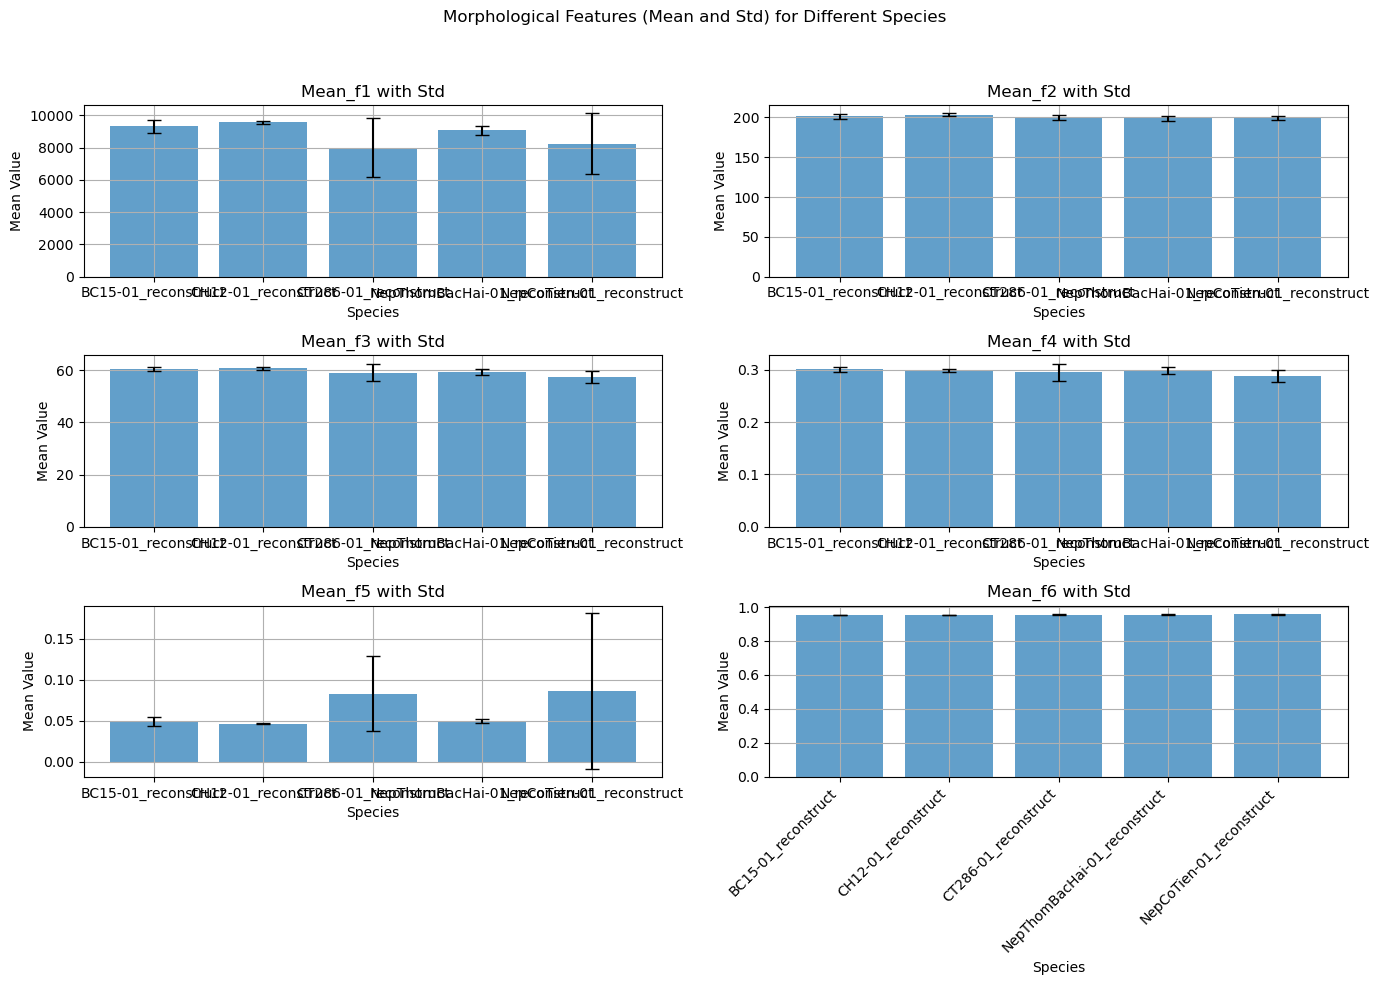

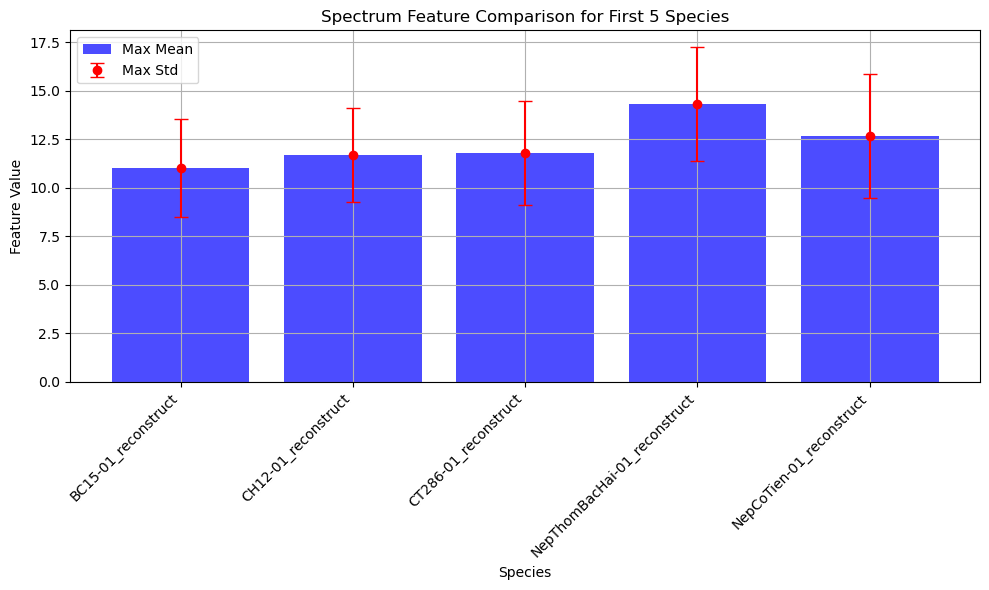

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Set the working directory
os.chdir(f'F:\\Hanoi project\\RGB and VIS-NIR HSI Data for 90 Rice Seed Varieties')

# Read morphological features and spectrum features from CSV
morphological_file = 'Morphological_all.csv'
spectrum_file = 'Spectrum_all.csv'

# Load the CSV data
morphological_data = pd.read_csv(morphological_file)
spectrum_data = pd.read_csv(spectrum_file)

# Function to filter species that end with '_reconstruct'
def filter_species(data, max_species=5):
    filtered_data = data[data['Species'].str.endswith('_reconstruct')]
    return filtered_data.groupby('Species').head(max_species)  # Get the first 5 species

# Filtered data for first 5 species ending with "_reconstruct"
filtered_morphological_data = filter_species(morphological_data)
filtered_spectrum_data = filter_species(spectrum_data)

# Function to plot mean and std for morphological features
def plot_morphological_features_with_mean_std(data):
    species = data['Species'].unique()[:5]  # Take first 5 species
    features = ['Mean_f1', 'Mean_f2', 'Mean_f3', 'Mean_f4', 'Mean_f5', 'Mean_f6']
    std_features = ['Std_f1', 'Std_f2', 'Std_f3', 'Std_f4', 'Std_f5', 'Std_f6']
    
    fig, axs = plt.subplots(3, 2, figsize=(14, 10))  # (3, 2) layout for 6 features
    axs = axs.ravel()  # Flatten axes array for easier access

    for idx, feature in enumerate(features):
        std_feature = std_features[idx]
        
        # Prepare data for the current feature
        mean_values = [data[data['Species'] == sp][feature].values[0] for sp in species]
        std_values = [data[data['Species'] == sp][std_feature].values[0] for sp in species]
        
        # Plot mean with error bars (standard deviation)
        species_labels = [sp for sp in species]
        axs[idx].bar(species_labels, mean_values, yerr=std_values, capsize=5, alpha=0.7)
        axs[idx].set_title(f'{feature} with Std')
        axs[idx].set_xlabel('Species')
        axs[idx].set_ylabel('Mean Value')
        axs[idx].grid(True)
    
    plt.suptitle('Morphological Features (Mean and Std) for Different Species')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Function to plot spectrum features with species on the x-axis
def plot_spectrum_features_together(data):
    species = data['Species'].unique()[:5]  # Take first 5 species

    plt.figure(figsize=(10, 6))

    # Create x-axis labels for species
    species_labels = [sp for sp in species]
    
    # Plot Max Mean and Max Std for each species
    max_means = [data[data['Species'] == sp]['Max Mean'].values[0] for sp in species]
    max_stds = [data[data['Species'] == sp]['Max Std'].values[0] for sp in species]
    
    # Plotting
    plt.bar(species_labels, max_means, label='Max Mean', color='b', alpha=0.7)
    plt.errorbar(species_labels, max_means, yerr=max_stds, fmt='o', color='r', label='Max Std', capsize=5)

    plt.title('Spectrum Feature Comparison for First 5 Species')
    plt.xlabel('Species')
    plt.ylabel('Feature Value')
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot morphological and spectrum features for the first 5 species ending with '_reconstruct'
plot_morphological_features_with_mean_std(filtered_morphological_data)
plot_spectrum_features_together(filtered_spectrum_data)


Morphological Similarity (RGB vs Reconstruct):
            Species  Cosine Similarity  Euclidean Distance
0           BC15-01           0.999772          239.908843
1           CH12-01           0.999903          162.306815
2          CT286-01           0.993532         1368.144795
3  NepThomBacHai-01           0.988922         1357.346377
4      NepCoTien-01           0.998688          663.563769

Wavprofile Similarity (HSI vs Reconstruct):
            Species  Cosine Similarity  Euclidean Distance
0           BC15-01           0.999914          377.743930
1           CH12-01           0.999944          590.539971
2          CT286-01           0.999928          522.610846
3  NepThomBacHai-01           0.999874          948.562459
4      NepCoTien-01           0.999897          737.014538


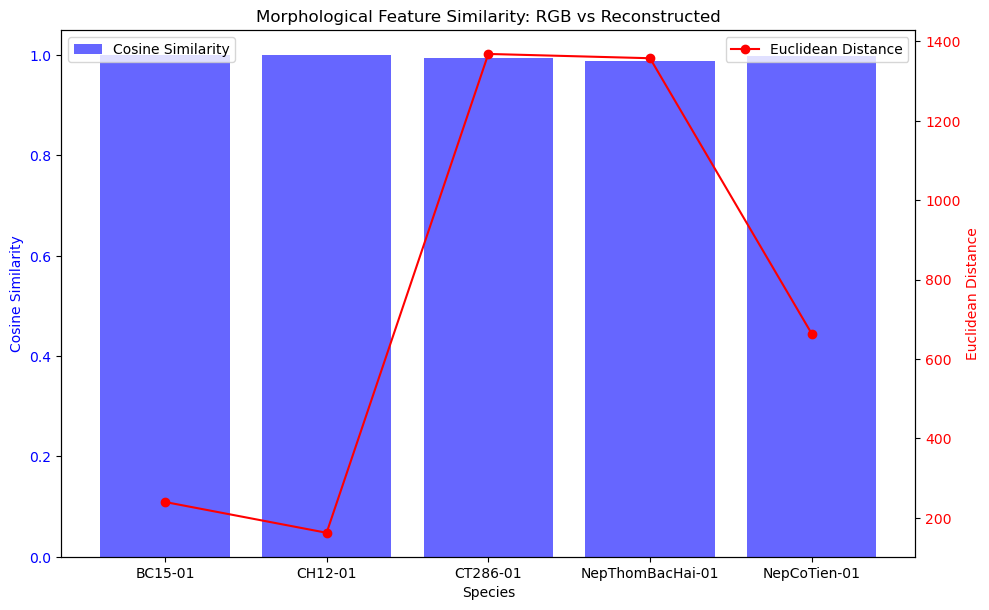

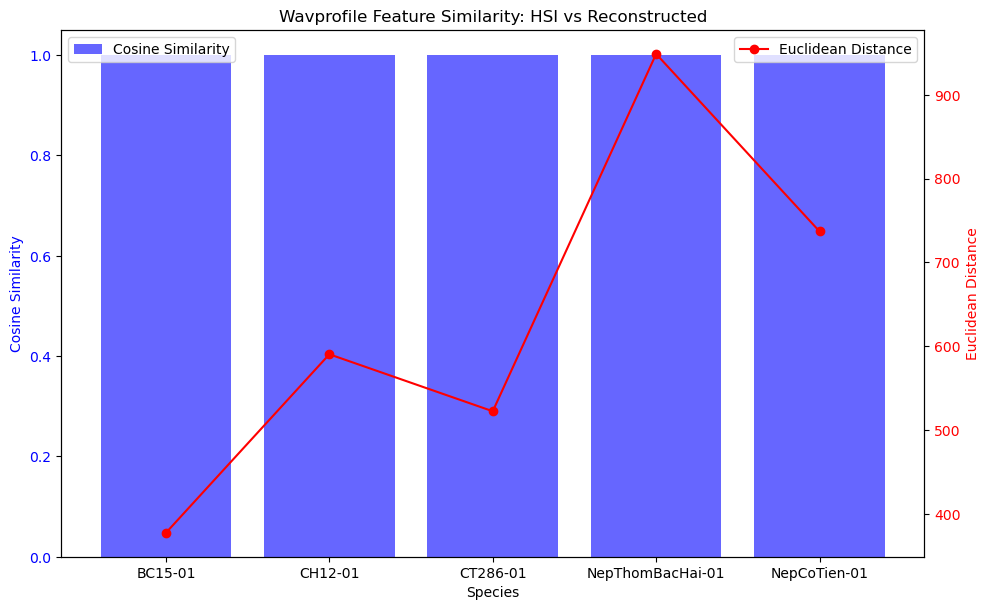

In [27]:


import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
import seaborn as sns
import matplotlib.pyplot as plt

# Define species list for filtering
species_list = ['BC15-01', 'CH12-01', 'CT286-01', 'NepThomBacHai-01', 'NepCoTien-01']

# Read the CSV files for morphological and wavprofile data
morphological_data = pd.read_csv('Morphological_all.csv')
wavprofile_data = pd.read_csv('wavprofile.csv')

# Function to filter species data based on suffix (_hsi, _rgb, _reconstruct)
def filter_species_data(data, species_list, suffix):
    filtered_data = pd.DataFrame()
    for species in species_list:
        species_data = data[data['Species'].str.startswith(species) & data['Species'].str.endswith(suffix)]
        filtered_data = pd.concat([filtered_data, species_data], axis=0)
    return filtered_data

# Filter the original data (ending with _hsi, _rgb) and reconstructed data (ending with _reconstruct)
filtered_morphological_rgb = filter_species_data(morphological_data, species_list, '_rgb')
filtered_morphological_reconstruct = filter_species_data(morphological_data, species_list, '_reconstruct')
filtered_wavprofile_hsi = filter_species_data(wavprofile_data, species_list, '_hsi')
filtered_wavprofile_reconstruct = filter_species_data(wavprofile_data, species_list, '_reconstruct')

# Define the morphological features and wavprofile features to compare
morphological_features = [
    'Mean_f1', 'Mean_f2', 'Mean_f3', 'Mean_f4', 'Mean_f5', 'Mean_f6',
    'Std_f1', 'Std_f2', 'Std_f3', 'Std_f4', 'Std_f5', 'Std_f6'
]

wavprofile_features = [col for col in wavprofile_data.columns if 'mean_' in col or 'std_' in col]

# Function to compute similarity between original and reconstructed features
def compute_similarity_for_species(original_data, reconstructed_data, features, species_list):
    similarity_results = []

    for species in species_list:
        # Extract the original and reconstructed data for the species
        original_species = original_data[original_data['Species'].str.contains(species)]
        reconstructed_species = reconstructed_data[reconstructed_data['Species'].str.contains(species + '_reconstruct')]

        if original_species.empty or reconstructed_species.empty:
            print(f"Data missing for {species}")
            continue
        
        # Extract feature vectors for the comparison
        original_features = original_species[features].values.flatten()
        reconstructed_features = reconstructed_species[features].values.flatten()

        # Compute Cosine Similarity
        cos_sim = cosine_similarity([original_features], [reconstructed_features])[0][0]
        
        # Compute Euclidean Distance
        euc_dist = euclidean(original_features, reconstructed_features)
        
        similarity_results.append({
            'Species': species,
            'Cosine Similarity': cos_sim,
            'Euclidean Distance': euc_dist
        })
    
    return pd.DataFrame(similarity_results)

# Compute similarity for Morphological (RGB vs Reconstructed)
morphological_similarity_df = compute_similarity_for_species(filtered_morphological_rgb, filtered_morphological_reconstruct, morphological_features, species_list)
print("Morphological Similarity (RGB vs Reconstruct):")
print(morphological_similarity_df)

# Compute similarity for Wavprofile (HSI vs Reconstructed)
wavprofile_similarity_df = compute_similarity_for_species(filtered_wavprofile_hsi, filtered_wavprofile_reconstruct, wavprofile_features, species_list)
print("\nWavprofile Similarity (HSI vs Reconstruct):")
print(wavprofile_similarity_df)

# Plot the similarity results
def plot_similarity_results(similarity_df, title):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    species = similarity_df['Species']
    
    # Plot Cosine Similarity
    ax1.set_xlabel('Species')
    ax1.set_ylabel('Cosine Similarity', color='b')
    ax1.bar(species, similarity_df['Cosine Similarity'], label='Cosine Similarity', color='b', alpha=0.6)
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend(loc='upper left')
    
    # Create another y-axis for Euclidean distance
    ax2 = ax1.twinx()
    ax2.set_ylabel('Euclidean Distance', color='r')
    ax2.plot(species, similarity_df['Euclidean Distance'], color='r', marker='o', label='Euclidean Distance')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Plot the similarity results for Morphological Features
plot_similarity_results(morphological_similarity_df, "Morphological Feature Similarity: RGB vs Reconstructed")

# Plot the similarity results for Wavprofile Features
plot_similarity_results(wavprofile_similarity_df, "Wavprofile Feature Similarity: HSI vs Reconstructed")


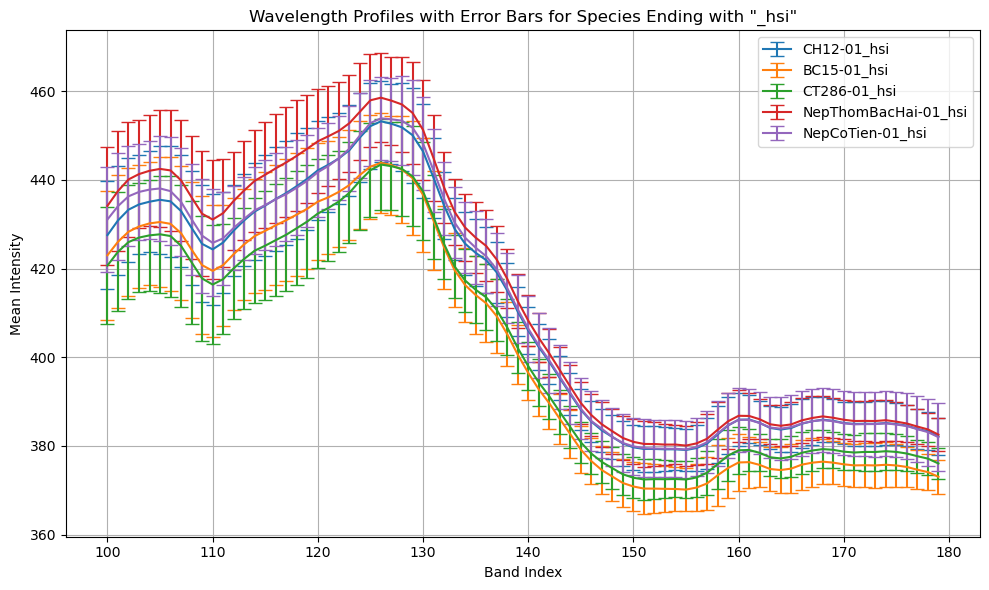

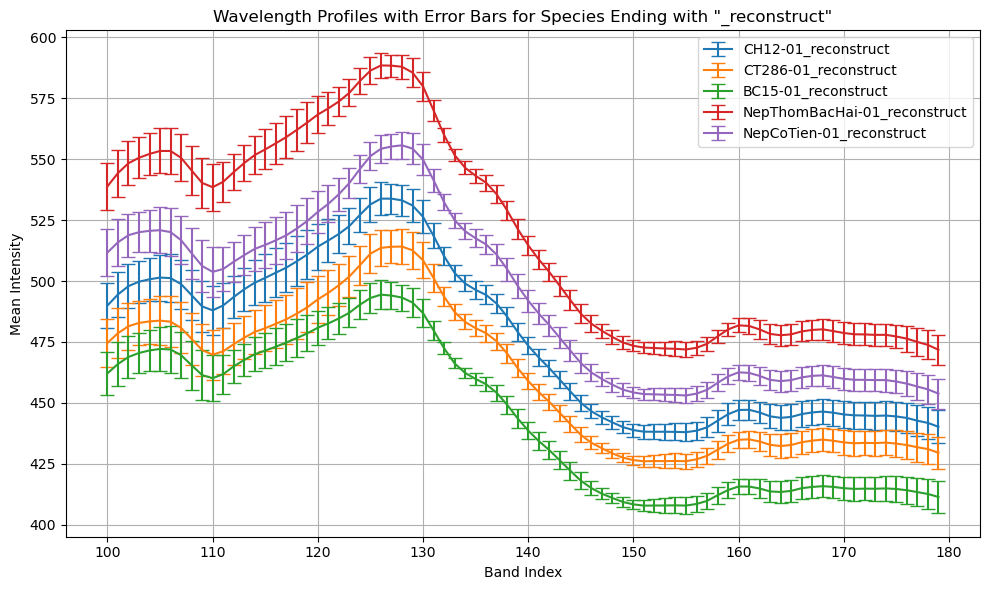

In [5]:
# Read the wavelength profile CSV file
wavprofile_file = 'wavprofile.csv'

# Load the CSV data
wavprofile_data = pd.read_csv(wavprofile_file)

# Function to plot wavelength profiles for species ending with '_hsi' and '_reconstruct' with error bars
def plot_wavelength_profiles_with_errorbars(data, species_suffix):
    filtered_data = data[data['Species'].str.endswith(species_suffix)]
    
    # Extract mean and std columns (assumes columns are named 'mean_100', 'std_100', etc.)
    mean_columns = [col for col in filtered_data.columns if col.startswith('mean_')]
    std_columns = [col for col in filtered_data.columns if col.startswith('std_')]
    
    # Extract the band indices (from 'mean_100', 'mean_101', ..., 'mean_179')
    band_indices = [int(col.split('_')[1]) for col in mean_columns]
    
    plt.figure(figsize=(10, 6))
    
    # Plot each species' wavelength profile with error bars
    for species in filtered_data['Species'].unique():
        species_data = filtered_data[filtered_data['Species'] == species]
        mean_wavelength_profile = species_data[mean_columns].values[0]  # Extract mean profile
        std_wavelength_profile = species_data[std_columns].values[0]    # Extract std profile
        
        # Plot with error bars
        plt.errorbar(band_indices, mean_wavelength_profile, yerr=std_wavelength_profile, label=species, capsize=5)
    
    plt.title(f'Wavelength Profiles with Error Bars for Species Ending with "{species_suffix}"')
    plt.xlabel('Band Index')
    plt.ylabel('Mean Intensity')
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Plot for species ending with '_hsi'
plot_wavelength_profiles_with_errorbars(wavprofile_data, '_hsi')

# Plot for species ending with '_reconstruct'
plot_wavelength_profiles_with_errorbars(wavprofile_data, '_reconstruct')